In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#read in data into dataframe
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## Data Exploration/Cleaning

In [3]:
#understand how much data there is
df.shape

(294478, 5)

In [4]:
df['user_id'].nunique()

290584

Calculating the proportion of users converted.

In [5]:
df['converted'].value_counts() / df.shape[0]

0    0.880341
1    0.119659
Name: converted, dtype: float64

Calculating the number of times the `new_page` and `treatment` don't line up.

In [6]:
#subsetting data and counting rows, by looking at index 0 of shape
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [7]:
#Non-Null count in output shows there are no missing values in any of the rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
#collecting index of rows of "bad data" to drop 
to_drop = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index

#drop rows
df2 = df.drop(to_drop, axis=0)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2['user_id'].nunique()

290584

In [11]:
(df2.user_id.value_counts() > 1)

773192     True
630732    False
811737    False
797392    False
795345    False
          ...  
650647    False
648598    False
654741    False
652692    False
630836    False
Name: user_id, Length: 290584, dtype: bool

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
#deleting rows with duplicate user_id
df2.drop_duplicates(subset = 'user_id',inplace=True)

#Check
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [14]:
#Because converted column is 1s and 0s, calculating the mean will result in the probability of lead conversion
df2.converted.mean()

0.11959708724499628

Calculating probility of conversion given that an individual was in the control group

In [15]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

Calculating probility of conversion given that an individual was in the treatment group

In [16]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

Probability of recieving a new page

In [17]:
df2['landing_page'].value_counts() / df2.shape[0]

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

### Insights from data exploration

**Based on the results above, there is not sufficient evidence to claim the new treatment page leads to more conversions. The overall conversion probability is 11.96% compared to a slightly lower 11.88% conversion probablity given that an individual is in the treatment group. Furthermore, the control group has the highest probability of conversion at 12.04%. However, it would be beneficial to create a confidence interval to understand whether this difference is statistically significant.**

### Part II - A/B Test

**Null Hypothesis: $p(new) - p(old) \le 0 $**

**Alternative Hyp: $p(new) - p(old) > 0 $**

Simulating 10,000 $p_{new}$ - $p_{old}$ values 

In [25]:
p_diffs = []

new = np.random.binomial(n_new, convert_rate, 10000)/n_new
old =  np.random.binomial(n_old, convert_rate, 10000)/n_old
p_diffs = new - old

p_diffs = np.asarray(p_diffs)

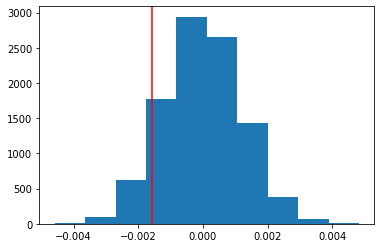

In [26]:
obs_diff = (df2[df2['landing_page'] == 'new_page']['converted'].mean()) - (df2[df2['landing_page'] == 'old_page']['converted'].mean())
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red')

Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [27]:
#1st way to solve for p-val
pval = (p_diffs > obs_diff).mean()
print("P-Value: ", pval)

#np.percentile(p_diffs, 0.05), np.percentile(p_diffs, 0.95)

P-Value:  0.9026


In [28]:
#2nd way to solve for p-val
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
(null_vals > obs_diff).mean()

0.9057

0.5111


0.9034

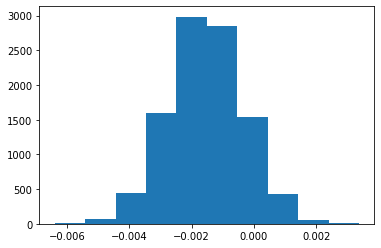

In [43]:
#3rd way to solve

df_old = df2[df2['landing_page'] == 'old_page']
df_new = df2[df2['landing_page'] == 'new_page']

diffs = []

for i in range(10000):
    new = df_new.sample(145310, replace=True)
    old = df_old.sample(145274, replace=True)
    diff = new['converted'].mean() - old['converted'].mean()
    diffs.append(diff)

diffs = np.asarray(diffs)

null_vals2 = np.random.normal(0, diffs.std(), diffs.size)
(null_vals2 > obs_diff).mean()

### Test Conclusion

**The p-value is extremely high, at 0.90. Under the normal distribtion aligning with the null hypothesis, we would expect to obtain the observed statistic or more extreme 90% of the time. This means that we fail to reject the null hypothesis of the old page conversion rate being better than or equal to the new page conversion rate.**

### Z-Test

In [29]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page']=='old_page']['converted'].sum()
convert_new = df2[df2['landing_page']=='new_page']['converted'].sum()

#check
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


In [30]:
#1 sides t-test where the alternative hyp states the difference in means is larger. Order of the parameters is important!!
z, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z,pval)

-1.3109241984234394 0.9050583127590245


**The z-score means that the observed statistic is 1.31 standard deviations greater than the mean. The p-value is not as high as what I calculated in the tests previously, but it is still large enough to suggest we fail to reject the null hypothesis.**

### A regression approach

**Logistic Regression**

In [31]:
df2['intercept']= 1
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = [1 if x =='treatment' else 0 for x in df2['group']]
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [32]:
log_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
log_reg.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:22:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### Log. Model Summary

**The p-value associated with the ab_page variable is 0.19, similar to to the p-value we observed in the one-sided ztest. Due to high value, we have sufficient evidence to fail to reject the null. Additionally the pseudo R-squared is extremely low, which means that the change in ab_page accounts for very little variation in the conversion variable.**

**It would be a good idea to consider variables factors like change aversion when implementing a new feature such as a new landing page. Given the extremely R-squared, the current model is weak. While adding more dimensions to this regression mdoel may improve the model, it is necessary to look out for multicollinearity and correlated errors.**

## Adding in country variable to dataset

In [39]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
### Create the necessary dummy variables
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,CA,UK,US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [41]:
### Fit Linear Model And Obtain the Results
df_new['intercept'] = 1

lm = sm.OLS(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'US']])
print(lm.fit().summary())

lm2 =sm.OLS(df_new['converted'], df_new[['intercept', 'CA', 'US']])
print(lm2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.640
Date:                Tue, 21 Jul 2020   Prob (F-statistic):              0.178
Time:                        20:35:01   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1214      0.001     90.150      0.0

**Adding in country does not improve the model. In fact the R-squared is 0 and the p-values for both CA and US are greater than 5%. Therefore, with the data provided, we do not have sufficient evidence to suggest that the new landing page conversion rate is greater than the old landing page conversion rate.**

### Interaction between Page and Country

In [42]:
#Adding interactions
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new['US_ab_page'] = df_new['US']*df_new['ab_page']
lm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'CA', 'US_ab_page', 'CA_ab_page']])
print(lm3.fit().summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:37:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.

## Conclusion
**Adding in interaction variables does not improve the model. R-squared value is minimal and p-values for all variables are statistically insignificant. I remain consistent in my conclusion - we do not have sufficient evidence to reject the null.** 